# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Video: TBA

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.train.csv'  # path to training data
tt_path = r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

'gdown' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'gdown' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


# **Import Some Packages**

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [4]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [48]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self, path, mu, std, mode='train', target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
#             feats = list(range(40)) + [
#                 40, 41, 42, 43, 47, 51, 56, 57, 58, 59, 60, 61, 65, 69, 74, 75,
#                 76, 77, 78, 79, 83, 87, 92
#             ]


#             feats=list(range(40))+[75]
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            indices_list = list(range(len(data)))
            #             np.random.shuffle(indices_list)
            train__indices, test_indices = train_test_split(indices_list,
                                                            test_size=0.1,
                                                            random_state=0)
            if mode == 'train':  # 7:3
                indices = train__indices
            elif mode == 'dev':
                indices = test_indices

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        if mode == 'train':
            self.mu = self.data[:, 40:].mean(dim=0, keepdim=True)
            self.std = self.data[:, 40:].std(dim=0, keepdim=True)
        else:
            self.mu = mu
            self.std = std

        self.data[:, 40:] = (self.data[:, 40:] - self.mu) / self.std

        self.dim = self.data.shape[1]

        print(
            'Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
            .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [49]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False,mu=None,std=None):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mu,std, mode=mode,target_only=target_only)  # Construct dataset
    if mode=='train':
        mu=dataset.mu
        std=dataset.std
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader,mu,std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [50]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
#             nn.Dropout(0.05),
            nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.LeakyReLU(),
            nn.Linear(64,1),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')


    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
#         return self.criterion(pred, target)
#         return torch.sqrt(self.criterion(pred, target)+1e-6)
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [51]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [52]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [53]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [54]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features
# torch.optim.Adam()
# TODO: How to tune these hyper-parameters to improve your model's performance?
# config = {
#     'n_epochs': 3000,                # maximum number of epochs
#     'batch_size': 270,               # mini-batch size for dataloader
#     'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
#     'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
#         'lr': 0.001,                 # learning rate of SGD
#         'momentum': 0.9              # momentum for SGD
#     },
#     'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
#     'save_path': r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\models\model.pth'  # your model will be saved here
# }
# torch.optim.RMSprop()
# torch.optim.SGD()
# torch.optim.Adam()
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,             # learning rate of SGD
        'momentum': 0.9,          # momentum for SGD
#         'weight_decay':0.0005
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\models\model.pth'  # your model will be saved here
}

# **Load data and model**

In [12]:
tr_set,tr_mu,tr_std = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set ,mu_none,std_none= prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only,mu=tr_mu,std=tr_std)
tt_set ,mu_none,std_none= prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only,mu=tr_mu,std=tr_std)

Finished reading the train set of COVID19 Dataset (2025 samples found, each dim = 63)
Finished reading the dev set of COVID19 Dataset (675 samples found, each dim = 63)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 63)


In [55]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [56]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 204.8727)
Saving model (epoch =    2, loss = 89.2707)
Saving model (epoch =    3, loss = 46.4793)
Saving model (epoch =    4, loss = 16.3028)
Saving model (epoch =    5, loss = 7.4380)
Saving model (epoch =    6, loss = 5.6564)
Saving model (epoch =    7, loss = 5.0463)
Saving model (epoch =    8, loss = 4.1776)
Saving model (epoch =    9, loss = 3.6471)
Saving model (epoch =   10, loss = 2.8921)
Saving model (epoch =   11, loss = 2.5281)
Saving model (epoch =   12, loss = 2.2636)
Saving model (epoch =   13, loss = 2.0796)
Saving model (epoch =   14, loss = 1.9180)
Saving model (epoch =   15, loss = 1.8254)
Saving model (epoch =   16, loss = 1.7542)
Saving model (epoch =   17, loss = 1.6815)
Saving model (epoch =   18, loss = 1.6013)
Saving model (epoch =   19, loss = 1.5560)
Saving model (epoch =   20, loss = 1.5263)
Saving model (epoch =   21, loss = 1.4720)
Saving model (epoch =   23, loss = 1.4215)
Saving model (epoch =   24, loss = 1.3944)
Saving

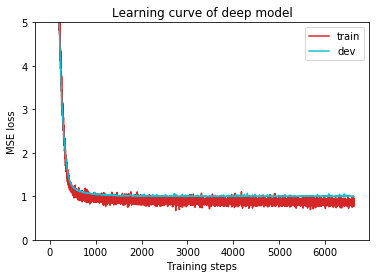

In [15]:
plot_learning_curve(model_loss_record, title='deep model')

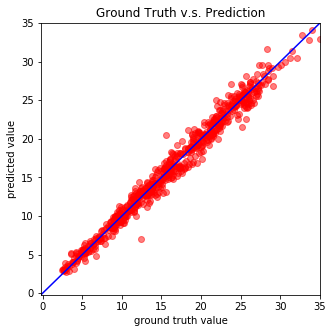

In [16]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Test**

In [17]:
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 1000,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,             # learning rate of SGD
        'momentum': 0.5,          # momentum for SGD
        'weight_decay':0.01
    },
    'early_stop': 500,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\models\model.pth'  # your model will be saved here
}

In [18]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 700),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(700, 400),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(400, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')


    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
#         return self.criterion(pred, target)
        return torch.sqrt(self.criterion(pred, target)+1e-6)

In [19]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [20]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 17.7966)
Saving model (epoch =    2, loss = 17.7716)
Saving model (epoch =    3, loss = 17.7458)
Saving model (epoch =    4, loss = 17.7193)
Saving model (epoch =    5, loss = 17.6921)
Saving model (epoch =    6, loss = 17.6642)
Saving model (epoch =    7, loss = 17.6353)
Saving model (epoch =    8, loss = 17.6058)
Saving model (epoch =    9, loss = 17.5750)
Saving model (epoch =   10, loss = 17.5431)
Saving model (epoch =   11, loss = 17.5099)
Saving model (epoch =   12, loss = 17.4753)
Saving model (epoch =   13, loss = 17.4386)
Saving model (epoch =   14, loss = 17.3998)
Saving model (epoch =   15, loss = 17.3587)
Saving model (epoch =   16, loss = 17.3150)
Saving model (epoch =   17, loss = 17.2683)
Saving model (epoch =   18, loss = 17.2177)
Saving model (epoch =   19, loss = 17.1630)
Saving model (epoch =   20, loss = 17.1033)
Saving model (epoch =   21, loss = 17.0374)
Saving model (epoch =   22, loss = 16.9654)
Saving model (epoch =   23, loss

Saving model (epoch =  407, loss = 1.0000)
Saving model (epoch =  444, loss = 0.9996)
Saving model (epoch =  452, loss = 0.9996)
Saving model (epoch =  458, loss = 0.9965)
Saving model (epoch =  488, loss = 0.9954)
Saving model (epoch =  497, loss = 0.9945)
Saving model (epoch =  523, loss = 0.9938)
Saving model (epoch =  526, loss = 0.9937)
Saving model (epoch =  551, loss = 0.9920)
Saving model (epoch =  560, loss = 0.9912)
Saving model (epoch =  575, loss = 0.9912)
Saving model (epoch =  608, loss = 0.9896)
Saving model (epoch =  639, loss = 0.9882)
Saving model (epoch =  654, loss = 0.9880)
Saving model (epoch =  670, loss = 0.9864)
Saving model (epoch =  776, loss = 0.9858)
Saving model (epoch =  779, loss = 0.9855)
Saving model (epoch =  791, loss = 0.9852)
Saving model (epoch =  795, loss = 0.9834)
Saving model (epoch =  824, loss = 0.9820)
Saving model (epoch =  865, loss = 0.9818)
Saving model (epoch =  906, loss = 0.9809)
Saving model (epoch =  939, loss = 0.9799)
Saving mode

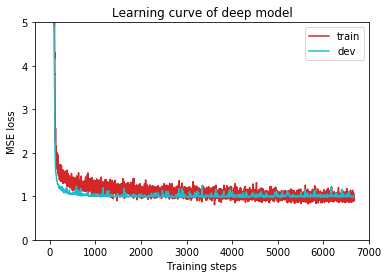

In [326]:
plot_learning_curve(model_loss_record, title='deep model')

In [320]:
model_loss_record['train'][-5:]

[0.9946780800819397,
 1.0154240131378174,
 1.1272647380828857,
 0.9462583065032959,
 0.8242942690849304]

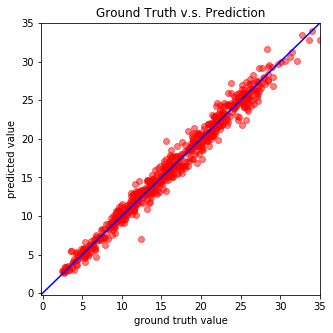

In [321]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Test2**

In [ ]:
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 1000,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,             # learning rate of SGD
        'momentum': 0.5,          # momentum for SGD
        'weight_decay':0.01
    },
    'early_stop': 500,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\models\model.pth'  # your model will be saved here
}

In [26]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 67),
            nn.ReLU(),
#             nn.Linear(134, 67),
#             nn.ReLU(),
            nn.Linear(67, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')


    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
#         return self.criterion(pred, target)
        return torch.sqrt(self.criterion(pred, target)+1e-6)

In [27]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 17.9414)
Saving model (epoch =    2, loss = 17.9045)
Saving model (epoch =    3, loss = 17.8679)
Saving model (epoch =    4, loss = 17.8313)
Saving model (epoch =    5, loss = 17.7946)
Saving model (epoch =    6, loss = 17.7579)
Saving model (epoch =    7, loss = 17.7210)
Saving model (epoch =    8, loss = 17.6839)
Saving model (epoch =    9, loss = 17.6465)
Saving model (epoch =   10, loss = 17.6087)
Saving model (epoch =   11, loss = 17.5703)
Saving model (epoch =   12, loss = 17.5311)
Saving model (epoch =   13, loss = 17.4911)
Saving model (epoch =   14, loss = 17.4504)
Saving model (epoch =   15, loss = 17.4090)
Saving model (epoch =   16, loss = 17.3664)
Saving model (epoch =   17, loss = 17.3226)
Saving model (epoch =   18, loss = 17.2772)
Saving model (epoch =   19, loss = 17.2305)
Saving model (epoch =   20, loss = 17.1823)
Saving model (epoch =   21, loss = 17.1322)
Saving model (epoch =   22, loss = 17.0805)
Saving model (epoch =   23, loss

Saving model (epoch =  196, loss = 3.6481)
Saving model (epoch =  197, loss = 3.5695)
Saving model (epoch =  198, loss = 3.4903)
Saving model (epoch =  199, loss = 3.4124)
Saving model (epoch =  200, loss = 3.3334)
Saving model (epoch =  201, loss = 3.2545)
Saving model (epoch =  202, loss = 3.1755)
Saving model (epoch =  203, loss = 3.0957)
Saving model (epoch =  204, loss = 3.0166)
Saving model (epoch =  205, loss = 2.9379)
Saving model (epoch =  206, loss = 2.8595)
Saving model (epoch =  207, loss = 2.7809)
Saving model (epoch =  208, loss = 2.7038)
Saving model (epoch =  209, loss = 2.6268)
Saving model (epoch =  210, loss = 2.5516)
Saving model (epoch =  211, loss = 2.4774)
Saving model (epoch =  212, loss = 2.4055)
Saving model (epoch =  213, loss = 2.3348)
Saving model (epoch =  214, loss = 2.2660)
Saving model (epoch =  215, loss = 2.2003)
Saving model (epoch =  216, loss = 2.1368)
Saving model (epoch =  217, loss = 2.0757)
Saving model (epoch =  218, loss = 2.0161)
Saving mode

Saving model (epoch =  613, loss = 1.0113)
Saving model (epoch =  623, loss = 1.0107)
Saving model (epoch =  625, loss = 1.0102)
Saving model (epoch =  633, loss = 1.0099)
Saving model (epoch =  636, loss = 1.0099)
Saving model (epoch =  638, loss = 1.0098)
Saving model (epoch =  640, loss = 1.0088)
Saving model (epoch =  646, loss = 1.0076)
Saving model (epoch =  650, loss = 1.0074)
Saving model (epoch =  657, loss = 1.0071)
Saving model (epoch =  664, loss = 1.0063)
Saving model (epoch =  667, loss = 1.0059)
Saving model (epoch =  669, loss = 1.0059)
Saving model (epoch =  674, loss = 1.0055)
Saving model (epoch =  675, loss = 1.0055)
Saving model (epoch =  681, loss = 1.0045)
Saving model (epoch =  687, loss = 1.0043)
Saving model (epoch =  694, loss = 1.0042)
Saving model (epoch =  702, loss = 1.0027)
Saving model (epoch =  704, loss = 1.0026)
Saving model (epoch =  710, loss = 1.0026)
Saving model (epoch =  712, loss = 1.0017)
Saving model (epoch =  723, loss = 1.0007)
Saving mode

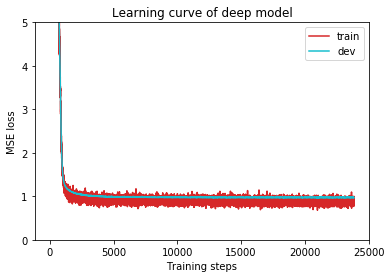

In [24]:
plot_learning_curve(model_loss_record, title='deep model')

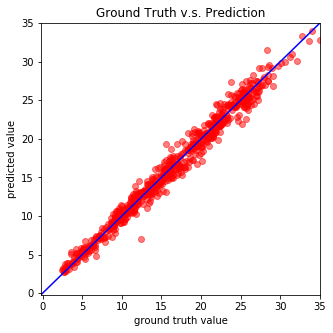

In [25]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# Test

In [336]:
k=5
val_loss=[]
num_val_sample=len(tr_set) // k

for i in range(5):
    print('Processing  Kfold: %d' % (i))
    
    val_data=tr_set.dataset.data[i * num_val_sample:(i+1) * num_val_sample,:]
    val_target=tr_set.dataset.target[i*num_val_sample:(i+1) * num_val_sample]
            
    partital_train_data=torch.cat(
        (tr_set.dataset.data[:i*num_val_sample,:],
        tr_set.dataset.data[(i+1) * num_val_sample:,:]),0
    )
    partital_train_target=torch.cat(
        (tr_set.dataset.target[:i*num_val_sample],
        tr_set.dataset.target[(i+1) * num_val_sample:]),0
    )
    
    
    model_loss, model_loss_record = train((partital_train_data,partital_train_target), 
                                          (val_data,val_target), 
                                          model, config, device)
    val_loss.append(model_loss)
print('val mean :',np.mean(val_loss))


Processing  Kfold: 0


ValueError: too many values to unpack (expected 2)

In [ ]:
for x,y in (partital_train_data,partital_train_target):
    

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [149]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\pred_hjc_mustd2.csv')         # save prediction file to pred.csv

Saving results to F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\pred_hjc_mustd2.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
